<p> <b> Disclaimer: </b> Visualizations and presentation of theory is heavily based on the excellent book by Yoav Goldberg "Neural network methods for natural language processing." Synthesis Lectures on Human Language Technologies 10.1 (2017) </p>

In [37]:
%matplotlib inline
from __future__ import division
import sys
import os
import time

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})


from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, TimeDistributed, Dense
from keras.preprocessing import sequence
from keras.datasets import imdb
from keras.utils import to_categorical
from keras import callbacks

import ner_data_loader

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
import keras
print(keras.__version__);

2.1.3


#  Recurrent Neural Netowk (RNN) Recap

## Example, forward pass of an RNN

In [ ]:
##input dimension d_x
input_dim = 10;
##output dimension d_s
output_dim = 5;

print('Input dimension: '+str(input_dim))
print('Output dimension: '+str(output_dim))

##input (sequence) lebgth
t = 100;
##input initialization
X = np.random.rand(input_dim,t);
print('Input shape: '+str(X.shape));

##state with dimension (1,d_s)
##set it to 0 (s_0) initially
s_i = np.expand_dims(np.zeros([output_dim]),0);
##and output at time t will also be an empty (for now) matrix with dimensions [output_dim,t]
y = np.zeros([output_dim,t]);
print(y.shape)

##lets initialize weights and biases
##state weight vector of dimension d_s x d_s
W_s = np.random.rand(output_dim, output_dim);
##bias vector of dimension d_s
b = np.random.rand(output_dim);
##input weight vector of dimension d_x x d_s
W_x = np.random.rand(input_dim,output_dim);


print('Weight and bias dimensions');
print('W_s '+str(W_s.shape));
print('b '+str(b.shape));
print('W_x '+str(W_x.shape))

##forward pass
for i in np.arange(0,t):
    ##compute g( s_{i-1}W^s + x_iW^x +b ) which will give you the new state, here g will be tanh
    ##get current input and put it in a shape of (1,dx)
    x_i = np.expand_dims(X[:,i],0);
    ##compute next state
    s_i_next = np.tanh(np.matmul(s_i,W_s) + np.matmul(x_i,W_x) + b);
    ##output
    y[:,i] = s_i_next;
    ##update state
    s_i = s_i_next;
    
    
    
    




## Vanishing gradients in recurrent networks 

This example is adapted from an excellent blogpost on the matter (with many awesome links therein) by A. karpathy
here: https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b

In [85]:
## Here we have a much simpler version of what we did above, we also assume that the activation
## function is a relu (aka max(0,z)). We follow the blog notation (code-wise) since we pretty much
## copy pasted it :-)

## We assume that there is no input to simplify even further the equations (or just say that input is
## a vector of zeros all the time)
H = 5; ##hidden input or output dimension
T = 50 ##time
WH = np.random.randn(H,H); ##state vector 


hs = {}; ##dictionary (key = time, value is hidden state before activation, aka what we had inside g)
ss = {}; ##dictionary (key = time, value is hidden state after activation, aka g())
hs[-1] = np.random.randn(H); ##initialize first state randomly

## Forward pass, same as we did before, here tanh() is replaced by relu
for t in xrange(T):    
    ss[t] = np.matmul(hs[t-1],WH) ##we 've seen that, it is what we had inside g() without the input (assumed to be zero)
    hs[t] = np.maximum(0, ss[t]); ##and activation
    
## Backward pass, we will store derivatives here
dhs = {}  ##same logic as with hs and ss but now we will store the derivatives
dss = {};
dhs[T-1] = np.random.randn(H); ##random gradients at the start

for t in reversed(xrange(T)):
    dss[t] = (hs[t] > 0)*dhs[t]; ##backprop through activation
    dhs[t-1] = np.dot(np.transpose(WH),dss[t]); ##&backprop to previous hidden state
    
"""
The trick, as pointed is the blog post is to realize as to what is happening in the last part
of the for loop... 
"""
    

# Gated Architectures (LSTM)

## Example, forward pass of a LSTM

In [68]:
##lets first quickly define the sigmoid function
def sigmoid(x):    
    return 1./(1. + np.exp(-x));

##input dimension d_x
input_dim = 100;
##hidden dimension = output dimension = memmory cell dimension
hidden_dim = 32;

##input (sequence) lebgth
t = 100;
##input initialization, as before
X = np.random.rand(input_dim,t);

##initialize memmory cell and hidden cell each of dimension d_h
h_i = np.expand_dims(np.zeros(hidden_dim),0);
c_i = np.expand_dims(np.zeros(hidden_dim),0);

##y output of dimension d_h x t
y = np.zeros([hidden_dim,t]);


##initialize weights and biases
##similar to what we had for the RNN before, weights associated with input will have a
##dimension of d_x x d_h, weights associated with hidden cells will have a dimension of d_h x d_h
W_xi = np.random.rand(input_dim,hidden_dim) ##input gate weights for input
W_hi = np.random.rand(hidden_dim,hidden_dim) ##input gate weights for hidden
b_i = np.random.rand(hidden_dim); ##input gate bias 

W_xf = np.random.rand(input_dim,hidden_dim) ##forget weights for input
W_hf = np.random.rand(hidden_dim,hidden_dim) ##forget weights for hidden
b_f = np.random.rand(hidden_dim); ##forget bias 

W_xo = np.random.rand(input_dim,hidden_dim) ##output weights for input
W_ho = np.random.rand(hidden_dim,hidden_dim) ##output weights for hidden
b_o = np.random.rand(hidden_dim); ##output gate bias 

W_xz = np.random.rand(input_dim,hidden_dim) ##update candidate weights for input
W_hz = np.random.rand(hidden_dim,hidden_dim) ##update candidate weights for hidden
b_z = np.random.rand(hidden_dim); ##update candidate gate bias 

##and lets do a forward pass example
for ii in np.arange(0,t):
    ##get current input and put it in a shape of (1,dx)
    x_i = np.expand_dims(X[:,ii],0);
    
    ##first we have the gatting mechanisms
    i = sigmoid( np.matmul(x_i,W_xi) + np.matmul(h_i,W_hi) + b_i ); ##input gate
    f = sigmoid( np.matmul(x_i,W_xf) + np.matmul(h_i,W_hf) + b_f ); ##forget gate
    o = sigmoid( np.matmul(x_i,W_xo) + np.matmul(h_i,W_ho) + b_o ); ##output gate        
    z = np.tanh( np.matmul(x_i,W_xz) + np.matmul(h_i,W_hz) + b_z); ##update candidate gate
    
    ##now we can compute the new memmory state
    c_i_next = f*c_i+i*z;
    ##and the next hidden state
    h_i_next = o*np.tanh(c_i_next);
    ##output and h_t are the same
    y[:,ii] = h_i_next
    ##update hidden and cell states   
    h_i = h_i_next;
    c_i = c_i_next;

# Many-to-one recurrent neural networks with Keras (Sentiment Detection)

<p> This section introduces variations of many-to-one recurrent neural networks with Keras. We start by loading a pre-processed example data set of imdb reviews. Sequences here are reviews and each sequence has a tag corresponding to a negative/positive review. Our goal is to use recurrent neural networks to perform sentiment analysis (aka predict the actual label of the sequence). </p>



## Many-to-one Architecture

![title](img/many_to_one_simple.jpg)


<b> Example of a many-to-one architecture </b>

## Loading and preparing the imdb data set

### 1. Load data
<p>For a detailed description of the load_data function see: https://keras.io/datasets/ </p>

<p>It is typical in many language tasks to exclude some words that are not frequent. These words will
be substituted under the hood with an UNK (unknown) token (2 in our case) </p>


In [51]:

## This variable let us select the number of most frequent words to use, set to None to select everything
max_num_words = 10000;
print('Loading data...');
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_num_words);
print('Done.');

Loading data...
Done.


In [52]:
## Now let's look at how our data are represented
print('Data types: ');
print('Sentences: '+str(type(x_train)));
print('Labels: '+str(type(y_train)));
print('Data shape:');
print('Sentences: '+str(x_train.shape)+' | labels: '+str(y_train.shape))

for i in range(2):
    print('Example data '+str(i));
    print(x_train[i]);
    print('Label: '+str(y_train[i]));
    print('---');



Data types: 
Sentences: <type 'numpy.ndarray'>
Labels: <type 'numpy.ndarray'>
Data shape:
Sentences: (25000,) | labels: (25000,)
Example data 0
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 1

<p> So our sentences are lists of integers, unknown words have been replaced with integer 2 while each sentence starts 
with integer 1 (the start of sentence symbol). In reality we always keep a dictionary that maps such integers to
the actual words (and usually a reverse dictionary as well)</p>


### 2. Preprocess data
<p>In the example above we observe that sentences have different length. In this first example architecture (many-to-one)
    we are going to train our networks in <b> batches </b> of sentences/labels. That means that all sentences in a batch should have the same size. To achieve that we will pad sentences by either truncating them (if their length is less than the maximum
desired length) or by adding a padding symbol until we reach the maximum desired length. Instead of doing this manually we will
rely on a pre-built keras function pad_sequences (see here for details: https://keras.io/preprocessing/sequence/). </p>


In [53]:
## Max sequence length
max_len = 500;
print('Shape before padding: '+str(x_train.shape));
x_train = sequence.pad_sequences(x_train, maxlen = max_len);
print('Number of unique words after padding: '+str(len(np.unique(x_train))));
print('Shape after padding: '+str(x_train.shape)); 


Shape before padding: (25000,)
Number of unique words after padding: 9999
Shape after padding: (25000, 500)


## Training many-to-one recurrent networks for sentiment detection

<p> At this point we are ready to train and evaluate our models. We will illustrate and discuss several architectures. Simple RNNs, 
LSTMs, stacked LSTMs, bidirectional LSTMs and LSTMs that use dropout for <b> regularization </b>. All models use the same
code structure to train (only the model definition changes + a few parameters) but we will repeat it for instructional purposes 
and just in case that you want to run a single model. </p>


### 1. RNN

#### Building the model

In [60]:
## We start by instantiating a Sequential keras model instance
rnn_model = Sequential();
## Now we add the Embedding vector, the embedding vector map integers to their corresponding tensors.
## according to the documentation the input dimension is equal to the largest integer (i.e., word_index) +1
## and this can get confusing... so do that and get over with it.
edim = np.max(np.unique(x_train)) +1;

## Next is our embedding dimension (32 in the following examples)
"""
Skip this part if running the notebook for the first time.

What happens if your initial weights, say for the embeddings are "too large"?
The output might also be large (in absolute sense always). Now you pass that
through a sigmoid function... the output will be binary (either 0 or 1). And your
derivative at this point will be zero as well... vanishing gradients problem again
(see also the Appendix section for a visualization of the sigmoid and the derivative
of the sigmoid)!

See (again) here for the same view of the problem (much better presented): 
https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b

Uncomment the following three lines and comment the 4th one below and play with the weight factor to
see how it affects training (e.g., try values 10,1 and 0.05).

Also, plot the loss, how does it look like?
"""
# weight_factor = 10.0;
# emb_weights = weight_factor*np.random.rand(edim,32); 
# rnn_model.add(Embedding(input_dim=edim,output_dim=32,trainable=True, weights=[emb_weights])); 
rnn_model.add(Embedding(input_dim=edim,output_dim=32)); 


## Now add a simple recurrent network with 32 units
rnn_model.add(SimpleRNN(32));   ##this is the only part that we will be changing from now on!
## and on top add our dense layer and top it with a signoid activation
rnn_model.add(Dense(1,activation='sigmoid'));

## Final step is to compile everything together, when we compile the model we need to specify
## what optimizer we are going to use, what loss are we going to use, and the metrics of interest
## to report. 
rnn_model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc']);

## And we can also see what we did
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


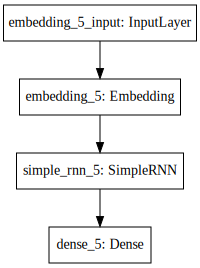

In [61]:
## We can also visualize things if we install pydot and graphviz... 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(rnn_model).create(prog='dot', format='svg'))

#### Training the model

In [62]:
## In these examples we will use the model fit function to train, the model fit function returns a 
## history object which is very useful when we want to visualize at the end our model's performance
## we will deal with the visualization part at the end when we will compare the performance of all
## recurrent neural networks. 



## For details and other options that you can use in the fit function see: https://keras.io/models/sequential/
stime = time.time();
rnn_history = rnn_model.fit(x_train, y_train,
                       epochs = 10, ##number of epochs (passes through the data)
                       batch_size = 128, ##batch size
                       validation_split = 0.2, ##fraction of data to be used as validation
                       shuffle = True ##shuffle data after each epoch
                       );
etime = time.time();
print('Total time: '+str(etime-stime));


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.7078 - acc: 0.5337 - val_loss: 0.6898 - val_acc: 0.5472
Epoch 2/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.6825 - acc: 0.5596 - val_loss: 0.6819 - val_acc: 0.5702
Epoch 3/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.6719 - acc: 0.5777 - val_loss: 0.6801 - val_acc: 0.5650
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.6638 - acc: 0.5876 - val_loss: 0.6778 - val_acc: 0.5686
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.6560 - acc: 0.5980 - val_loss: 0.6669 - val_acc: 0.5760
Epoch 6/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.6488 - acc: 0.6100 - val_loss: 0.6736 - val_acc: 0.5740
Epoch 7/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.6421 - acc: 0.6192 - val_loss: 0.6628 - val_acc:

### 2. LSTM

We follow exactly the same process as illustrated on the case of the RNN, the ONLY thing that changes
is the type of the recurrent layer that we will use (and the fact that we now have fewer comments and
do not plot summaries or architectures for the models)

In [ ]:
lstm_model = Sequential();
lstm_model.add(Embedding(input_dim=edim,output_dim=32,mask_zero=True)); 

##instead of a simple rnn now define a LSTM
lstm_model.add(LSTM(32));   

lstm_model.add(Dense(1,activation='sigmoid'));

lstm_model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc']);

stime = time.time();
lstm_history = lstm_model.fit(x_train, y_train,
                       epochs = 10, ##number of epochs (passes through the data)
                       batch_size = 128, ##batch size
                       validation_split = 0.2, ##fraction of data to be used as validation
                       shuffle = True ##shuffle data after each epoch
                       );
etime = time.time();
print('Total time: '+str(etime-stime));

### 3. LSTM + dropout


![title](img/lstm_dropout.jpg)


<b> Dropout in recurrent networks. </b>

In [ ]:
drop_lstm_model = Sequential();
drop_lstm_model.add(Embedding(input_dim=edim,output_dim=32,mask_zero=True)); 

## Lets add some dropout to our basic LSTM. dropout here is to the input/output connection and recurrent to
## the recurrent connection as we have illustrated in the figure above
drop_lstm_model.add(LSTM(32,dropout=0.8, recurrent_dropout=0.75));   

drop_lstm_model.add(Dense(1,activation='sigmoid'));

drop_lstm_model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc']);

stime = time.time();
drop_lstm_history = drop_lstm_model.fit(x_train, y_train,
                       epochs = 10, ##number of epochs (passes through the data)
                       batch_size = 128, ##batch size
                       validation_split = 0.2, ##fraction of data to be used as validation
                       shuffle = True ##shuffle data after each epoch
                       );
etime = time.time();
print('Total time: '+str(etime-stime));

### 4. Stacked LSTM

![as](img/lstm_stacked.jpg)


<b> Example of a stacked recurrent architecture. </b>

<p>An interesting idea of using hierarchical architectures for sentiment detection is to have a first RNN decode sentences (or spans of words in a sentence) and a second one accepting such sentence representations. Intuition is that the first RNN learns sentiment of sentences while the second one learns sentiment of the document based on sentiment of sentences. See <i> Tang, Duyu, Bing Qin, and Ting Liu. "Document modeling with gated recurrent neural network for sentiment classification." Proceedings of the 2015 conference on empirical methods in natural language processing. 2015.</i></p>

In [ ]:
stacked_lstm_model = Sequential();
stacked_lstm_model.add(Embedding(input_dim=edim,output_dim=32,mask_zero=True)); 

## Instead of a LSTM we will define a stacked - hierarchical LSTM. The trick is that
## the next LSTM layer needs input from the previous layer, so what we need to do
## is to ask for the first layer to return its sequences. So by setting return sequences = True
## we do not only return the last output of the input sequence but the full output
stacked_lstm_model.add(LSTM(32, return_sequences = True));   
## Lets add one more layer on top
stacked_lstm_model.add(LSTM(16));


stacked_lstm_model.add(Dense(1,activation='sigmoid'));

stacked_lstm_model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc']);

stime = time.time();
stacked_lstm_history = stacked_lstm_model.fit(x_train, y_train,
                       epochs = 10, ##number of epochs (passes through the data)
                       batch_size = 128, ##batch size
                       validation_split = 0.2, ##fraction of data to be used as validation
                       shuffle = True ##shuffle data after each epoch
                       );
etime = time.time();
print('Total time: '+str(etime-stime));

### 5. Bidirectional LSTM

![title](img/lstm_bidirectional.jpg)


<b> Example architecture of a bidirectional recurrent architecture. </b>

In [ ]:
bilstm_model = Sequential();
bilstm_model.add(Embedding(input_dim=edim,output_dim=32,mask_zero=True)); 

## Instead of a simple rnn now define a LSTM
## bi-directional is a wrapper layer here that hides from us the fact that it
## runs separately two LSTMs and then concats the output
bilstm_model.add(Bidirectional(LSTM(32)));   

bilstm_model.add(Dense(1,activation='sigmoid'));

bilstm_model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc']);



stime = time.time();
bilstm_history = bilstm_model.fit(x_train, y_train,
                       epochs = 10, ##number of epochs (passes through the data)
                       batch_size = 128, ##batch size
                       validation_split = 0.2, ##fraction of data to be used as validation
                       shuffle = True ##shuffle data after each epoch
                       );
etime = time.time();
print('Total time: '+str(etime-stime));

## Results - Visualization

In [ ]:
plt.figure(figsize=[15,8]);

## First we will plot the train and validation(test) accuracy at each epoch.
## The history returned from the fit(...) method has everything we need!
plt.plot(rnn_history.history['acc'],'-bo',linewidth=2,label='RNN Train');
plt.plot(lstm_history.history['acc'],'-ro',linewidth=2,label='LSTM Train');
plt.plot(drop_lstm_history.history['acc'],'-go',linewidth=2,label='LSTM + dropout Train');
plt.plot(stacked_lstm_history.history['acc'],'-mo',linewidth=2,label='Stacked LSTM Train');
plt.plot(bilstm_history.history['acc'],'-ko',linewidth=2,label='BiLSTM Train');

plt.plot(rnn_history.history['val_acc'],':bo',linewidth=2,label='RNN Test');
plt.plot(lstm_history.history['val_acc'],':ro',linewidth=2,label='LSTM Test');
plt.plot(drop_lstm_history.history['val_acc'],':go',linewidth=2,label='LSTM + dropout Test');
plt.plot(stacked_lstm_history.history['val_acc'],':mo',linewidth=2,label='Stacked LSTM Test');
plt.plot(bilstm_history.history['val_acc'],':ko',linewidth=2,label='BiLSTM Test');

plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.legend();

In [ ]:
plt.figure(figsize=[15,8]);
## Then we will plot the train and validation(test) loss at each epoch.
plt.plot(rnn_history.history['loss'],'-bo',linewidth=2,label='RNN Train');
plt.plot(lstm_history.history['loss'],'-ro',linewidth=2,label='LSTM Train');
plt.plot(drop_lstm_history.history['loss'],'-go',linewidth=2,label='LSTM + dropout Train');
plt.plot(stacked_lstm_history.history['loss'],'-mo',linewidth=2,label='Stacked LSTM Train');
plt.plot(bilstm_history.history['loss'],'-ko',linewidth=2,label='BiLSTM Train');

plt.plot(rnn_history.history['val_loss'],':bo',linewidth=2,label='RNN Test');
plt.plot(lstm_history.history['val_loss'],':ro',linewidth=2,label='LSTM Test');
plt.plot(drop_lstm_history.history['val_loss'],':go',linewidth=2,label='LSTM + dropout Test');
plt.plot(stacked_lstm_history.history['val_loss'],':mo',linewidth=2,label='Stacked LSTM Test');
plt.plot(bilstm_history.history['val_loss'],':ko',linewidth=2,label='BiLSTM Test');

plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

# Many-to-many recurrent neural netwokrs 

## The problem

<p> In this section we will deal with the problem of <b> named entity recognition </b>. As the name suggests the problem is, given a sentence (e.g., John lives in New York and works at Facebook) to identify the (named) entities in that sentence (John, New York, Facebook) as well as the entity type (Person, Location, Organization).  </p>

<p> It is easy to understand that in this problem our input to the recurrent network will be a sequence and the output will also be a sequence (of named entities) as well - a "many-to-many" relationship. </p>

<p> Here is an example of a tagged sentence from our data: </p>

EU  B-ORG <br/>
rejects  O <br/>
German  B-MISC <br/>
call  O <br/>
to  O <br/>
boycott  O <br/>
British  B-MISC <br/>
lamb   O <br/>
.  O <br/>

<p> The tags of the dataset are MISC,PER,ORG,LOC and O corresponding to miscellaneous, person, organization, location and "other" respectively. Each tag has a prefix B/I which determines the order of the named entity (e.g., New York -> B-LOC I-LOC) </p>

![title](img/many_to_many_simple.jpg)


<b> Many-to-one architecture example.  </b>

## Loading and parsing the data

To keep things cleaner, and for time's shake we will use the <b> ner_data_loader.py </b> script to load the data. The script is well documented and you can refer to it after the end of the class to see the details. Functions in there are pretty trivial and deal mostly with parsing files and getting everything to a shape similar to what we get from the imdb.load_data() function

In [5]:
fname = "train.txt"; #filename holding the data, should be at the same folder as this notebook, else specify a full path

##step 1. Load the raw data, keep sentences with length ranging from [min_length, max_length]
sentences, sentence_labels = ner_data_loader.load_data(fname,min_length=5,max_length=64,)
##step 2. construct dictionaries mapping words and labels to integer indices and vice versa
word_to_ind, ind_to_word, label_to_ind, ind_to_label = ner_data_loader.get_dictionaries(sentences, sentence_labels);
##step 3. Bring the data to the same format (list of lists) that we used in the imdb.load_data() function.
## here we do not use a start symbol.
sentences_ind = ner_data_loader.to_index(sentences,word_to_ind);
sentence_labels_ind = ner_data_loader.to_index(sentence_labels, label_to_ind);

Parsing data
Done.
Sentences: 11373
Max sentence length: 62
Min sentence length: 5
Unique words on corpus: 23624
Unique labels on corpus: 9
Pruning non-frequent words, keeping top 20000
Unique words in data: 19522
Unique labels in data: 9


In [11]:
print('Sentence example: ');
print(sentences_ind[0]);
print('Labels for sentence');
print(sentence_labels_ind[0])

Sentence example: 
[2, 3, 4, 5, 6, 7, 8, 9, 10]
Labels for sentence
[1, 2, 3, 2, 2, 2, 3, 2, 2]


## Preparing the data

Similarly to what we did before we will start by padding the sentences to the same length. 
Since now the labels are not 0/1 but have the same length as the corresponding sentence, 
labels will need to be padded as well.

In [12]:
max_len = 64;  ##max sentence length
x_train = sequence.pad_sequences(sentences_ind, maxlen=max_len);
y_train = sequence.pad_sequences(sentence_labels_ind, maxlen=max_len)


We are dealing with categorical data and not with a binary 0/1 example. So what we need to do is to
one-hot encode the binary labels in sentence_labels_ind to one hot-vectors. We will use the function
below to do so.

In [13]:

"""
Function that one-hot encodes the integer labels. 

Inputs:
    y_train (nd-array): An array of size [samples, max_len] holding the padded labels of each sentence
Returns:
    y_train_onehot (nd-array): An array of size [samples, max_len, one_hot_vector_size]. The one hot vector
    length is 1 + the original labels (the +1 comes for the padding symbol)
"""
def one_hot_encode(y_train):
    ##dimensions ndata x time_ x labels+1
    n_labels_p1 = len(np.unique(y_train)); ##number of labels +1 since y_train is padded
    y_train_onehot = np.zeros([y_train.shape[0], y_train.shape[1], n_labels_p1]); 
    
    for i in np.arange(y_train.shape[0]):
        for j in np.arange(y_train.shape[1]):
            y_train_onehot[i][j] = to_categorical(y_train[i][j], n_labels_p1);
    return y_train_onehot;

In [14]:
##and let's one hot encode...
print('Shape before... '+str(y_train.shape));
y_train = one_hot_encode(y_train);
print('Shape after... '+str(y_train.shape));
print('Example 1-hot label for the first word of the first sentence')
print(y_train[0][0])

Shape before... (11373, 64)
Shape after... (11373, 64, 10)
Example 1-hot label for the first word of the first sentence
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Building and compiling the model 

In [15]:
##nothing to see here same as before
embedding_input_dim = np.max(np.unique(x_train))+1;
embedding_dim = 128;
hidden_size = 64;
mlp_size = 32;
n_outputs = len(label_to_ind)+1;
batch_size = 64;


In [16]:
## Here's the main model.
ner_model = Sequential();
## Important part number one, we will need to use the TimeDistributed WRAPPER. That wrapper applies a
## layer to each (temporal) part of the sequence (we'll discuss it more in class).
## So, we need to use set input_length argument, which signifies that all sequences will have
## a fixed size of max_len (the maximum sentence length defined earlier)
ner_model.add(Embedding(input_dim=embedding_input_dim, 
                        output_dim=embedding_dim, 
                        mask_zero=False,
                        input_length = max_len));

## Important part number two, our LSTMs NEEEEED to return the sequences so we can apply a layer/function
## to all the parts of the sequence. 

ner_model.add(Bidirectional(
            LSTM(hidden_size, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
          ));


# ner_model.add(SimpleRNN(2, return_sequences=True));

# #ner_model.add(LSTM(128, return_sequences=True));


## We use softmax since n_classes > 1 to get a pseudo-probability for each class
ner_model.add(TimeDistributed(Dense(mlp_size)));
ner_model.add(Dense(n_outputs, activation='softmax'));

#ner_model.add(TimeDistributed(Dense(n_outputs, activation='softmax')));

## We also need to use categorical crossentropy (which implies > 1 classes with 1 hot vectors)
ner_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop',metrics=['acc']);

## And, we ready to roll
ner_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 128)           2498944   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 32)            4128      
_________________________________________________________________
dense_2 (Dense)              (None, 64, 10)            330       
Total params: 2,602,218
Trainable params: 2,602,218
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [17]:
ner_model.fit(x_train, y_train, epochs=10, batch_size=32, 
              validation_split=0.2,shuffle=True,
              callbacks = [callbacks.TensorBoard(log_dir="./logs", histogram_freq=1, write_grads=True)]
             );

Train on 9098 samples, validate on 2275 samples
Epoch 1/10
9098/9098 [==============================] - 108s 12ms/step - loss: 0.1929 - acc: 0.9503 - val_loss: 0.1014 - val_acc: 0.9684
Epoch 2/10
9098/9098 [==============================] - 105s 11ms/step - loss: 0.0677 - acc: 0.9796 - val_loss: 0.0701 - val_acc: 0.9803
Epoch 3/10
9098/9098 [==============================] - 103s 11ms/step - loss: 0.0363 - acc: 0.9899 - val_loss: 0.0549 - val_acc: 0.9844
Epoch 4/10
9098/9098 [==============================] - 104s 11ms/step - loss: 0.0229 - acc: 0.9938 - val_loss: 0.0480 - val_acc: 0.9859
Epoch 5/10
9098/9098 [==============================] - 105s 12ms/step - loss: 0.0165 - acc: 0.9956 - val_loss: 0.0454 - val_acc: 0.9871
Epoch 6/10
9098/9098 [==============================] - 104s 11ms/step - loss: 0.0129 - acc: 0.9965 - val_loss: 0.0484 - val_acc: 0.9854
Epoch 7/10
9098/9098 [==============================] - 104s 11ms/step - loss: 0.0109 - acc: 0.9972 - val_loss: 0.0452 - val_acc: 

To start tensorboard just run the command <b> tensorboard --logdir /path/to/log0directory </b>

## Let's predict something 
(to prove to your parents/boss/significant other that they spent that GPU money wisely)

In [24]:
## Sentence we are trying to identify named entities forb
sentence = "My name is John Arghten and I work at Microsoft Corp";


In [25]:
## we follow the same paradigm and we transform the sentence to a padded sequence

split_sentence = sentence.split(' ');
indexed_sentence = [];
for word in split_sentence:
    if(not word in word_to_ind):
        indexed_sentence.append(word_to_ind["UNK"]);
    else:
        indexed_sentence.append(word_to_ind[word])

##remember, we need to add the batch dimension    
indexed_sentence = np.expand_dims(indexed_sentence,0);
##and our model is expecting a sentence of length 64 so pad...
indexed_sentence = sequence.pad_sequences(indexed_sentence,maxlen=max_len);


In [26]:
## and the results...
pred_classes = ner_model.predict_classes(indexed_sentence);
pred_classes = pred_classes.flatten();
indexed_sentence = indexed_sentence.flatten();

for i in range(len(pred_classes)):
    try:
        print(ind_to_word[indexed_sentence[i]]+'\t'+ind_to_label[pred_classes[i]])
    except KeyError:
        pass;


My	O

name	O

is	O

John	B-PER

UNK	I-PER

and	O

I	O

work	O

at	O

Microsoft	B-ORG

Corp	I-ORG



# This is the end (Sometimes life is unfair)

In [ ]:
##suppose that you want to add pre-trained Embeddings to an LSTM or whatever...
##here's a "pre-trained" vector
embeddings = np.random.rand(5,8); ##vocabulary is 5 words and embeddings have 8 dims


In [ ]:
##how to add the embeddings???
##let's read the documentation (https://keras.io/layers/embeddings/)
##nothing there... 
## but embedding is an instance of the engine.base_layer.Layer and there
## you have options such as trainable and weights = ... 
## I can not find anything on the documentation though (so there might be another
## way to manually set weights and freeze a layer but @!### off I'm stupid ok?)

##in any way let's move on

##simple model...
model = Sequential();
##add Embedding layer 5 inputs 8 outputs, tell keras not to train it and then set your own embeddings
model.add(Embedding(input_dim=5,output_dim=8,trainable=False,weights=embeddings));

In [ ]:
##now google that error and good luck
##do not forget to feel bad about yourself...
##somehow, somewhere I got the following "brilliant" idea, because sometimes people are just evil
model.add(Embedding(input_dim=5,output_dim=8,trainable=False,weights=[embeddings]));

In [ ]:
##yes...
##aha...
##mhhhmmm...
## from the author of keras: https://blog.keras.io/user-experience-design-for-apis.html
## but ok, it is a great library to do stuff.

# Appendix 

## Visualization of sigmoid & its derivative (on vanishing gradients)

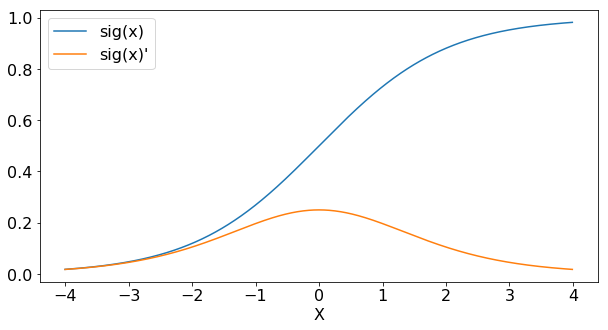

In [75]:
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x));
plt.figure(figsize=[10,5]);
plt.plot(np.arange(-4,4,.01),sigmoid(np.arange(-4,4,.01)),label='sig(x)');
plt.plot(np.arange(-4,4,.01),sigmoid_derivative(np.arange(-4,4,.01)),label='sig(x)\'');
plt.legend();
plt.xlabel('X');
